In [ ]:
!pip install transformers
!pip install torch

In [1]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/MyDrive/tripadvisor_aspect_reviews.csv',sep='\t')

print(df.head())
print(df.info())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

In [ ]:
from transformers import pipeline


    hotel_id                           user_id  \
0  127781101  2262DCBFC351F42A9DD30AC8BAD24686   
1  137380592  8477E11DABF4D6743885E401BB4C8CCF   
2  129673371  483A193B7113ADFFD5CE30849564F69C   
3  129006626  E5A63DD7239A7057746D4644A5C986EB   
4  139168159  CBFE281C9386225267BC52518836A6C2   

                                               title  \
0                            Really excellent Hilton   
1                    Exceptional service and comfort   
2                    Nice room and five star service   
3  BRILLIANT hotel, my #1 Chicago pick for busine...   
4                         Convenient and comfortable   

                                                text  overall  cleanliness  \
0  Stayed here on business trips and the hotel is...      5.0          4.0   
1  Spent two nights here for a wedding in Brookly...      5.0          5.0   
2  Great place for a 3-night stay. Our king room ...      5.0          5.0   
3  This is my favorite hotel in Chicago, and I've.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



✅ Model Performance for CLEANLINESS
Accuracy: 86.63 %

Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.63      0.67      1325
     Neutral       0.44      0.30      0.35      2162
    Positive       0.91      0.96      0.94     16643

    accuracy                           0.87     20130
   macro avg       0.68      0.63      0.65     20130
weighted avg       0.85      0.87      0.86     20130



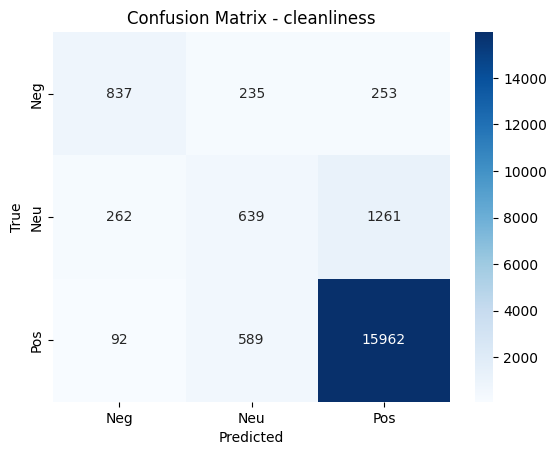

The room was very clean and spacious → Positive
The location was noisy and uncomfortable → Positive
The cleanliness was average, could be better → Positive


In [2]:
# ==========================================
# Aspect-Based Sentiment Analysis (Polarity, SVM)
# ==========================================

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.linear_model import LogisticRegression # Import Logistic Regression
from imblearn.over_sampling import RandomOverSampler # Import RandomOverSampler

# ==========================================
# 1. Load Dataset
# ==========================================
# df = pd.read_csv("tripadvisor_dataset.csv", sep='\t')  # adjust separator if needed
# The dataset was loaded in a previous cell, but it seems the separator was incorrect.
# We will reload the dataset with the correct separator.
df = pd.read_csv('/content/drive/MyDrive/tripadvisor_aspect_reviews.csv', sep=',')
# print(df.head()) # Commenting out to reduce output
# print(df.info()) # Commenting out to reduce output

# Combine title + text for richer context
df['review_text'] = df['title'].fillna('') + " " + df['text'].fillna('')
df.dropna(subset=['review_text'], inplace=True)

# ==========================================
# 2. Clean Review Text
# ==========================================
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)

df['cleaned_text'] = df['review_text'].apply(clean_text)

# ==========================================
# 3. Convert Ratings → Polarity (-1, 0, 1)
# ==========================================
def to_polarity(rating):
    if rating > 3: return 1      # Positive
    elif rating < 3: return -1   # Negative
    else: return 0               # Neutral

# Choose one aspect to start
aspect = 'cleanliness'  # you can change this later

df = df.dropna(subset=[aspect])
df['polarity'] = df[aspect].apply(to_polarity)

# ==========================================
# 4. Feature Extraction (Bag of Words)
# ==========================================
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=2, max_df=0.2)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['polarity']

# ==========================================
# 5. Train-Test Split
# ==========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# ==========================================
# Apply Resampling (RandomOverSampler)
# ==========================================
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# print("Original dataset shape %s" % Counter(y_train)) # Optional: check distribution before resampling
# print("Resampled dataset shape %s" % Counter(y_resampled)) # Optional: check distribution after resampling


# ==========================================
# 6. Train SVM Model
# ==========================================
svm = LinearSVC(class_weight='balanced', random_state=42, max_iter=10000)
# Train on the resampled data
svm.fit(X_resampled, y_resampled)


# ==========================================
# 7. Evaluate Model
# ==========================================
y_pred = svm.predict(X_test)
print("\n✅ Model Performance for", aspect.upper())
print("Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative','Neutral','Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neg','Neu','Pos'], yticklabels=['Neg','Neu','Pos'])
plt.title(f'Confusion Matrix - {aspect}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==========================================
# 8. Predict New Reviews
# ==========================================
def predict_sentiment(review_text):
    cleaned = clean_text(review_text)
    vec = vectorizer.transform([cleaned])
    pred = svm.predict(vec)[0]
    return { -1: "Negative", 0: "Neutral", 1: "Positive" }[pred]

# Test on custom examples
samples = [
    "The room was very clean and spacious",
    "The location was noisy and uncomfortable",
    "The cleanliness was average, could be better",
    "The stay was terrible", # Added the negative sample
    "It was ok, nothing special" # Added a neutral sample
]

for s in samples:
    print(f"{s} → {predict_sentiment(s)}")

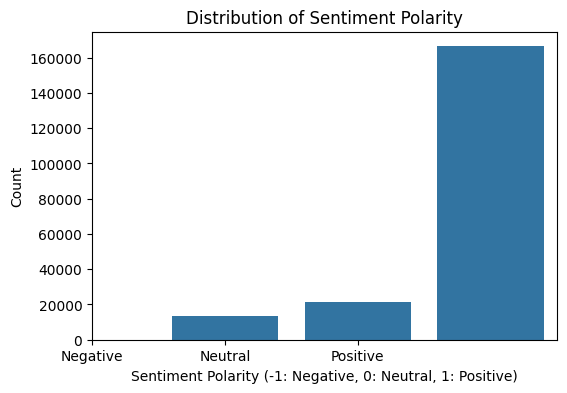


Sentiment Polarity Distribution:
polarity
 1    166424
 0     21619
-1     13252
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check the distribution of the 'polarity' column
plt.figure(figsize=(6, 4))
sns.countplot(x='polarity', data=df)
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity (-1: Negative, 0: Neutral, 1: Positive)')
plt.ylabel('Count')
plt.xticks(ticks=[-1, 0, 1], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

print("\nSentiment Polarity Distribution:")
print(df['polarity'].value_counts())

In [4]:
samples1 = [
    "The stay was terrible",
]

for s in samples1:
    print(f"{s} → {predict_sentiment(s)}")

The stay was terrible → Positive
